# LRS: Task 1.2 - Lidar Data and Bounding Boxes

### Loading data into python
First we need to load some libraries
* os - module in Python provides a way of using operating system dependent
functionalit
* numpy - adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays

**Disclaimer:** Parts are this Notebook are refererred from work done by Mr. Felix Beres (felix.berens@rwu.de) at Hochschule Ravensburg Weingarten.

In [75]:
import os
import numpy as np

In [76]:
# Set up the directories from where dataset is to be loaded

root = "/home/sa0102/lidar/dataset_astyx_hires2019/dataset_astyx_hires2019"
label_dir = os.path.join(root, "groundtruth_obj3d")
image_dir = os.path.join(root, "camera_front")
calib_dir = os.path.join(root, "calibration")
radar_dir = os.path.join(root, "radar_6455")
lidar_dir = os.path.join(root, "lidar_vlp16")

In [77]:
print('Total number of scenes in dataset are: {}'. format(len(os.listdir(label_dir))))

Total number of scenes in dataset are: 546


### Choose a random scene ID and plot the corresponding camera image

The filename consits of 6 numbers with zeros leading, so if our index is 77 then the filename is 000077. The file format is .jpg.
We will use the library cv2 for loading the images.

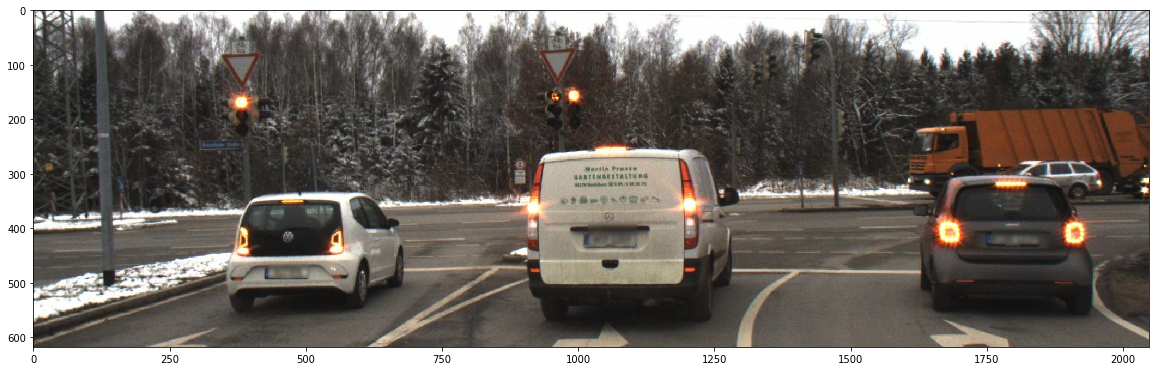

In [78]:
idx = 77

import cv2
img = cv2.imread(os.path.join(image_dir, "%06d.jpg" % idx)) # read image

import matplotlib.pyplot as plt

# Converted from BGR to RGB for visualization in matplolib
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (20,20))
plt.imshow(img)

### Segregating Scenes and objects based in distance

The groundtruth data of a specified scene is saved in directory 'label_dir'. The data can be accessed by opening the json file. We need to access the 'objects' dictionary one by one (there may be many in one scene) and then the information stored under 'center3d'. This 'center3d' dictionary has position (in x,y,z axes) and orientation of the corresponsing object. We access the position of every object and classify them based on distance from ego vehicle.

Note: For simplicity in distance measurement, only x co-ordinate is considered to classify.

In [79]:
# Initialize empty lists, in these the info of scene, object number will be appended as arrays.

dist_05 = [] # dist approx 5 mtr
dist_10 = [] # dist approx 10 mtr
dist_15 = [] # dist approx 15 mtr
dist_20 = [] # dist approx 20 mtr

In [80]:
import json

for k in range(len(os.listdir(label_dir))):
    filename = (os.path.join(label_dir, "%06d.json" % k))
    
    with open(filename) as f:
        val = json.load(f)
        
        for m in range(len(val['objects'])):
            
            if 4.0 <= val['objects'][m]['center3d'][0] < 6.0:
                # append scene and object number to list
                dist_05.append(np.array([k,m]))
            
            if 9.0 <= val['objects'][m]['center3d'][0] < 11.0:
                # append scene and object number to list
                dist_10.append(np.array([k,m]))
            
            if 14.0 <= val['objects'][m]['center3d'][0] < 16.0:
                # append scene and object number to list
                dist_15.append(np.array([k,m]))
            
            if 18.0 <= val['objects'][m]['center3d'][0] < 22.0:
                # append scene and object number to list
                dist_20.append(np.array([k,m]))
    

In [81]:
print('Total objects found with approx dist 10 mtr = {}.'.format(len(dist_10)))

Total objects found with approx dist 10 mtr = 117.


### Calibration matrices - To denote all data in a common co-ordinate frame

The groundtruth data of a specified scene is saved in directory 'calib_dir'. The data can be accessed by opening the json file. The loaded calib data is of type dictionary. With only one key "sensors". There are the three sensor stored in a list consiting of three dictionaries. For every sensor one dictionary.
0. radar
1. lidar
2. camera

For every sensor we have a 4×4 matrix to map the data from one coordinate system to the master coordinate system (RADAR coordinate system). Also for camera we have the matrix K 3×3, which can be used to map points from the radar coordinate system on the field of view of the camera.

In [82]:
class calib_astyx_1(file):
    """Calibration class"""
    def __init__(self, file):
        with open(file) as json_file:
            data = json.load(json_file)

        self.radar2ref = np.array(data["sensors"][0]["calib_data"]["T_to_ref_COS"])
        self.lidar2ref = np.array(data["sensors"][1]["calib_data"]["T_to_ref_COS"])
        self.camera2ref = np.array(data["sensors"][2]["calib_data"]["T_to_ref_COS"])
        self.K = np.array(data["sensors"][2]["calib_data"]["K"])

 **Transformation of LiDAR points**

We have to note that the LiDAR points and the RADAR points are in different coordinate systems.
So we will transfer the LiDAR points into the coordinate system of the RADAR points.
For this we will use the the homogeneous coordinate system (x,y,z) -> (x,y,z,1) and multiply this with the ĺidar to reference matrix.

In [83]:
class calib_astyx_2(calib_astyx_1):
    def trans_lidar2ref(self, points):
        n = points.shape[0]

        points_hom = np.hstack((points, np.ones((n,1))))
        points_ref = np.dot(points_hom, np.transpose(self.lidar2ref))

        return points_ref[:,0:3]


3D is easy for a human to understand and interpret. But for a computer 2D formats can be easier. So we map the data onto 2D. We can map it into bird's eye view (BEV) or onto the camera field of view (FOV).

First the camera FOV:

### FOV

In [84]:
class calib_astyx_3(calib_astyx_2):
    def __init__(self, file):
        super(calib_astyx_3,self).__init__(file)
        self.ref2camera = self.inv_trans(self.camera2ref)
        
    @staticmethod
    def inv_trans(T):
        rotation = np.linalg.inv(T[0:3, 0:3])
        translation = T[0:3, 3]
        translation = -1 * np.dot(rotation, translation.T)
        translation = np.reshape(translation, (3, 1))
        Q = np.hstack((rotation, translation))

        return Q

    def REF2FOV(self, points, img_size):
        obj_camera = np.dot(self.ref2camera[0:3, 0:3], points.T)
        T = self.ref2camera[0:3, 3]
        obj_camera = obj_camera + T[:, np.newaxis]
        obj_image = np.dot(self.K, obj_camera)
        obj_image = obj_image / obj_image[2]
        obj_image = np.delete(obj_image, 2, 0)
        mask = (obj_image[0,:] <= img_size[0]) & (obj_image[1,:] <= img_size[1]) & \
                (obj_image[0,:] >= 0) & (obj_image[1,:] >= 0) & \
                (points[:,0] >= 0) 
        return obj_image[:, mask] , mask

### Bounding Box

In [85]:
class Object3d:
    def __init__(self, obj):
        self.type= obj["classname"] 
        self.score = obj["score"]
        self.occlusion = obj["occlusion"]
        self.h = obj["dimension3d"][2]
        self.w = obj["dimension3d"][1]
        self.l = obj["dimension3d"][0]
        self.t = (obj["center3d"][0],obj["center3d"][1],obj["center3d"][2])
        self.quat = np.array(obj["orientation_quat"])
        self.rotationmatrix = self.get_rotationmatrix()
        
        self.bbox = self.get_bbox()
        self.angle = self.qaut_to_angle()[2]
        if self.angle >=0:
            self.angle = self.angle * 180 / np.pi
        else:
            self.angle = self.angle * 180 / np.pi + 360

    def qaut_to_angle(self):
        w = self.quat[0]
        x = self.quat[1]
        y = self.quat[2]
        z = self.quat[3]
        return(np.arctan2(2*(w*x+y*z),1-2*(x*x+y*y)),
               np.arcsin(2*(w*y-z*x)),
               np.arctan2(2*(w*z+x*y),1-2*(y*y+z*z)))

    def get_rotationmatrix(self):
        n = np.dot(self.quat, self.quat)
        if n < np.finfo(self.quat.dtype).eps:
            rot_matrix = np.identity(4)
            return rot_matrix
        q = self.quat * np.sqrt(2.0 / n)
        q = np.outer(q, q)
        rot_matrix = np.array(
            [[1.0 - q[2, 2] - q[3, 3], q[1, 2] + q[3, 0], q[1, 3] - q[2, 0]],
             [q[1, 2] - q[3, 0], 1.0 - q[1, 1] - q[3, 3], q[2, 3] + q[1, 0]],
             [q[1, 3] + q[2, 0], q[2, 3] - q[1, 0], 1.0 - q[1, 1] - q[2, 2]]],
            dtype=q.dtype)
        rot_matrix = np.transpose(rot_matrix)
        return rot_matrix
    
    def get_bbox(self):
        center = np.array(self.t)
        dimension = np.array([self.l, self.w, self.h])

        w = dimension[0] + 0.1
        l = dimension[1] + 0.1
        h = dimension[2] 

        x_corners = [-w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2, w / 2]
        y_corners = [l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2]
        z_corners = [h / 2, h / 2, h / 2, h / 2, -h / 2, -h / 2, -h / 2, -h / 2]

        R = self.rotationmatrix
        bbox = np.vstack([x_corners, y_corners, z_corners])
        bbox = np.dot(R, bbox)
        bbox = bbox + center[:, np.newaxis]

        bbox = np.transpose(bbox)

        return bbox
    


### Main func: Compute measurements based on Scene and Obj ID

In [86]:
def count_points(idn,car):
    
    # Load LiDAR data
    lidar = np.loadtxt(os.path.join(lidar_dir, "%06d.txt" % idn), skiprows=1, dtype=np.float32)
    
    # Transformation of lidar
    calib2 = calib_astyx_3(os.path.join(calib_dir, "%06d.json" % idn))
    
    lidar[:,0:3] = calib2.trans_lidar2ref(lidar[:,0:3])
    
    # Load Img
    img = cv2.imread(os.path.join(image_dir, "%06d.jpg" % idn)) # read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Lidar 3d to FOV
    lidar_fov, lidar_fov_mask  = calib2.REF2FOV(lidar[:,0:3], [img.shape[1], img.shape[0]])
    
    # Load groundtruth
    with open(os.path.join(label_dir, "%06d.json" % idn), "r") as json_file:
        truth = json.load(json_file)
        print('Distance between Ego and Observed Vehicle = {} mtr.'.format(truth['objects'][car]["center3d"][0]))
    
    # Rotation
    rot = [truth['objects'][car]['orientation_quat'][0], truth['objects'][car]['orientation_quat'][1],truth['objects'][car]['orientation_quat'][2],truth['objects'][car]['orientation_quat'][3]]
    
    print('Rotation in quaternions is {}'.format(rot))
    
    
    # Extract bbox
    for l in truth:
        objects = [Object3d(obj) for obj in truth["objects"]]
        
    corners_on_image = [calib2.REF2FOV(obj.bbox,  [img.shape[1], img.shape[0]]) for obj in objects ]
    
    # Plot bbox
    img_obj = cv2.rectangle(img, (int(corners_on_image[car][0][0].min()), int(corners_on_image[car][0][1].min())), (int(corners_on_image[car][0][0].max()), int(corners_on_image[car][0][1].max())), (255,255,255), 2)

    # Get 4 corners
    a1=(corners_on_image[car][0][0].min())
    a2=(corners_on_image[car][0][0].max())
    b1=(corners_on_image[car][0][1].min())
    b2=(corners_on_image[car][0][1].max())
    
    # Compute the LiDAR points inside box
    lid1 = []
    lid2 = []
    lid_mask = [False] * len(lidar_fov_mask)
    
    for i in range(len(lidar_fov[0])):
        if a1<lidar_fov[0][i]<a2 and b1<lidar_fov[1][i]<b2:
            lid1.append(lidar_fov[0][i])
            lid2.append(lidar_fov[1][i])
            lid_mask[i]=True
    lid= np.array([lid1, lid2])     
    
    #Plot
    plt.figure(figsize=(30,10))
    plt.scatter(lid[0], lid[1], c = lidar[lid_mask,3], s=100, cmap = "GnBu")
    plt.colorbar()
    plt.imshow(img)
    plt.axis("off")
    
    # Count
    print('Total LiDAR measurements for Observed vehicle = {}'.format(len(lid[0])))
    #rint('Total LiDAR measurements for given object = {}'.format(len(lid[1])))
    

### Test RUN

Distance between Ego and Observed Vehicle = 14.18 mtr.
Rotation in quaternions is [0.9992488714358169, -0.031940326355938506, -0.01807124868862436, -0.01244742774055521]
Total LiDAR measurements for Observed vehicle = 85


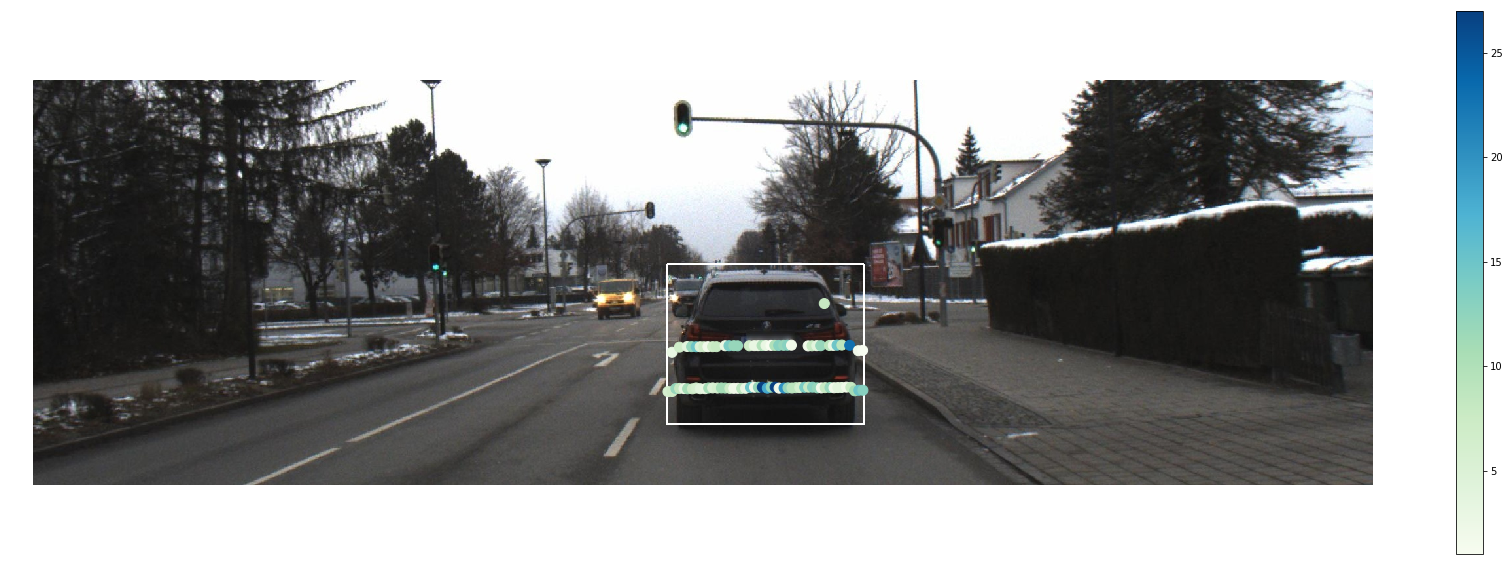

In [87]:
count_points(197,0)

Distance between Ego and Observed Vehicle = 10.1556656121 mtr.
Rotation in quaternions is [0.9997673842099288, -0.01826179583732543, -0.011393879887099468, 0.0013652047285150869]
Total LiDAR measurements for Observed vehicle = 217


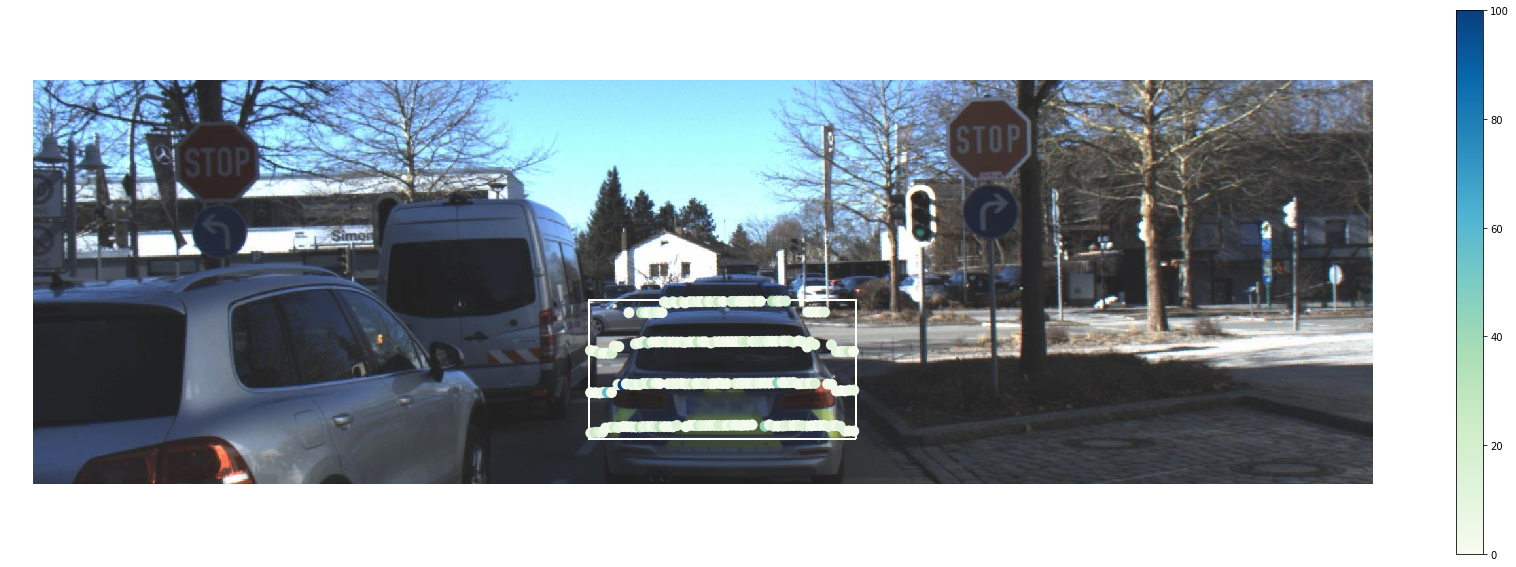

In [88]:
count_points(519,0)

Distance between Ego and Observed Vehicle = 11.8776427417 mtr.
Rotation in quaternions is [-0.99334178492361, 0.030059721412601544, 0.021217820026341958, 0.10917103822307038]
Total LiDAR measurements for Observed vehicle = 305


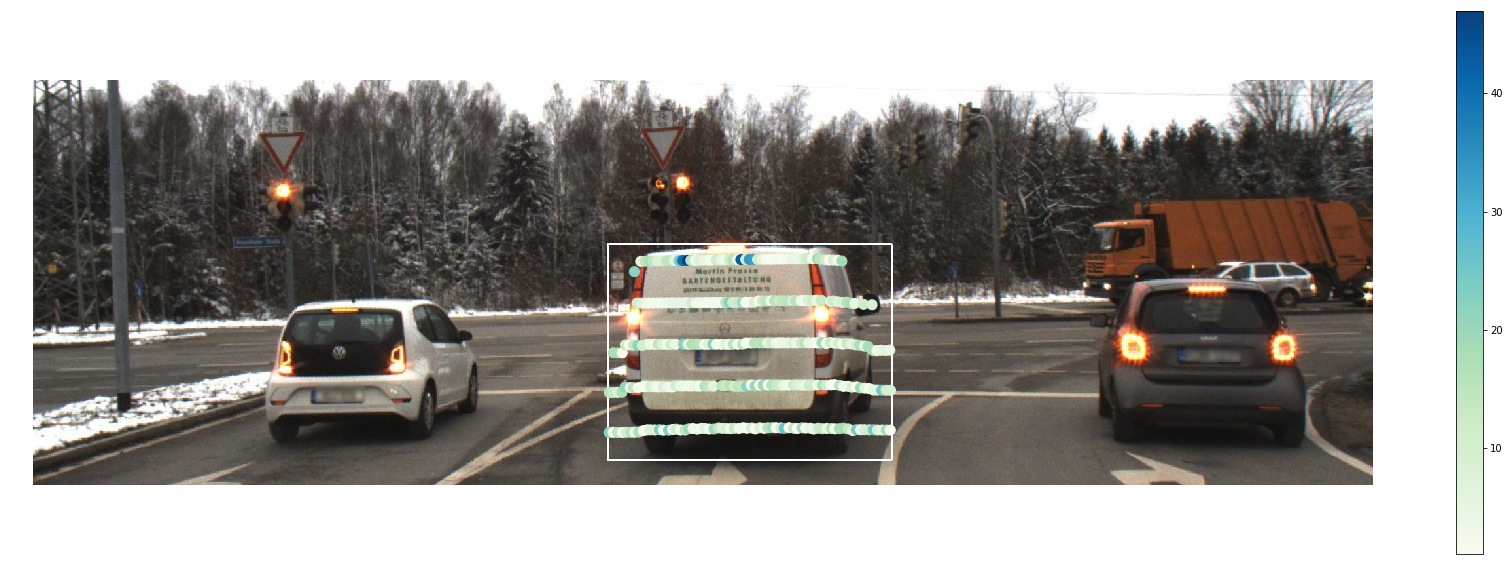

In [89]:
count_points(77,2)

## Just Plot all LiDAR points

In [90]:
def plot(idn,car):
    
    # Load LiDAR data
    lidar = np.loadtxt(os.path.join(lidar_dir, "%06d.txt" % idn), skiprows=1, dtype=np.float32)
    
    # Transformation of lidar
    calib2 = calib_astyx_3(os.path.join(calib_dir, "%06d.json" % idn))
    
    lidar[:,0:3] = calib2.trans_lidar2ref(lidar[:,0:3])
    
    # Load Img
    img = cv2.imread(os.path.join(image_dir, "%06d.jpg" % idn)) # read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Lidar 3d to FOV
    lidar_fov, lidar_fov_mask  = calib2.REF2FOV(lidar[:,0:3], [img.shape[1], img.shape[0]])
    
    # Load groundtruth
    with open(os.path.join(label_dir, "%06d.json" % idn), "r") as json_file:
        truth = json.load(json_file)
    
    # Extract bbox
    for l in truth:
        objects = [Object3d(obj) for obj in truth["objects"]]
        
    corners_on_image = [calib2.REF2FOV(obj.bbox,  [img.shape[1], img.shape[0]]) for obj in objects ]
    
    # Plot bbox
    img_obj = cv2.rectangle(img, (int(corners_on_image[car][0][0].min()), int(corners_on_image[car][0][1].min())), (int(corners_on_image[car][0][0].max()), int(corners_on_image[car][0][1].max())), (255,255,255), 2)

    # Get 4 corners
    a1=(corners_on_image[car][0][0].min())
    a2=(corners_on_image[car][0][0].max())
    b1=(corners_on_image[car][0][1].min())
    b2=(corners_on_image[car][0][1].max())
    
    # Compute the LiDAR points inside box
    lid1 = []
    lid2 = []
    lid_mask = [False] * len(lidar_fov_mask)
    
    for i in range(len(lidar_fov[0])):
        if a1<lidar_fov[0][i]<a2 and b1<lidar_fov[1][i]<b2:
            lid1.append(lidar_fov[0][i])
            lid2.append(lidar_fov[1][i])
            lid_mask[i]=True
    lid= np.array([lid1, lid2])     
    
    #Plot
    plt.figure(figsize=(30,10))
    plt.scatter(lidar_fov[0], lidar_fov[1], c = lidar[lidar_fov_mask,3], s=100, cmap = "GnBu")
    plt.colorbar()
    plt.imshow(img)
    plt.axis("off")
    
    # Count
    #print('Total LiDAR measurements for given object = {}'.format(len(lid[0])))
    #print('Total LiDAR measurements for given object = {}'.format(len(lid[1])))
    

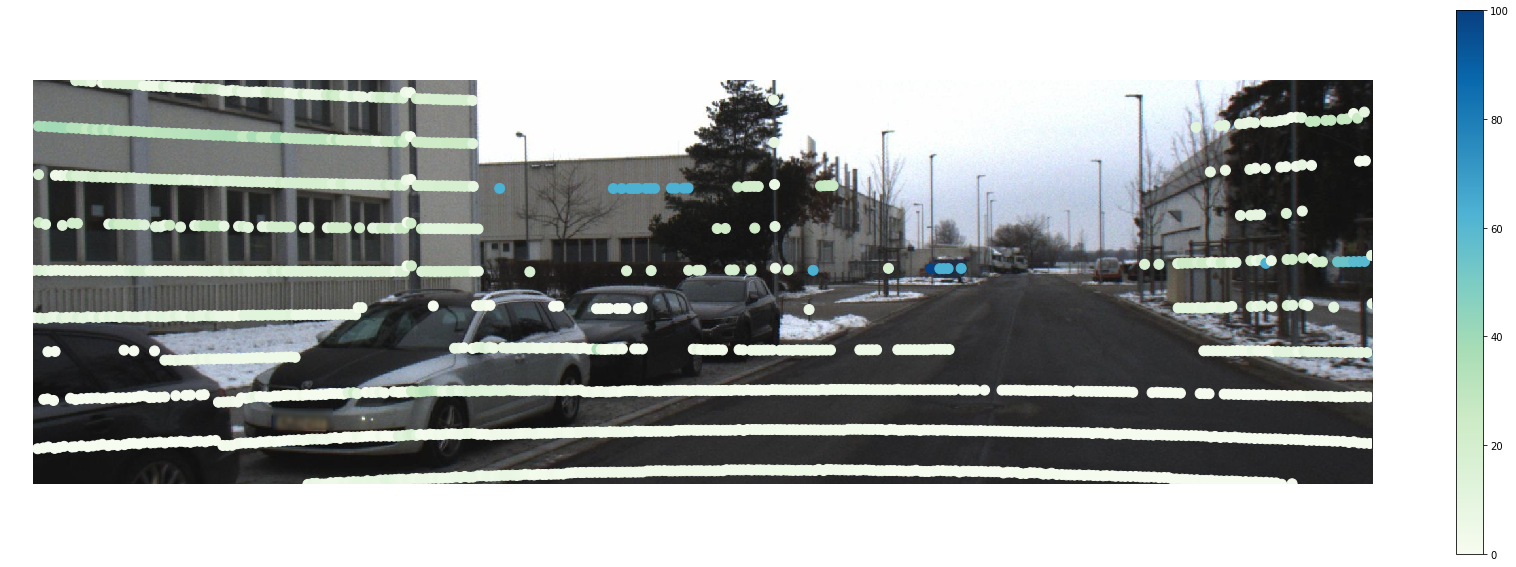

In [91]:
plot(31,3)

## Special Cases

Distance between Ego and Observed Vehicle = 5.31360765426 mtr.
Rotation in quaternions is [-0.10893609430976206, 0.021072067160763635, -0.03004445282994096, -0.9933711422203972]
Total LiDAR measurements for Observed vehicle = 0


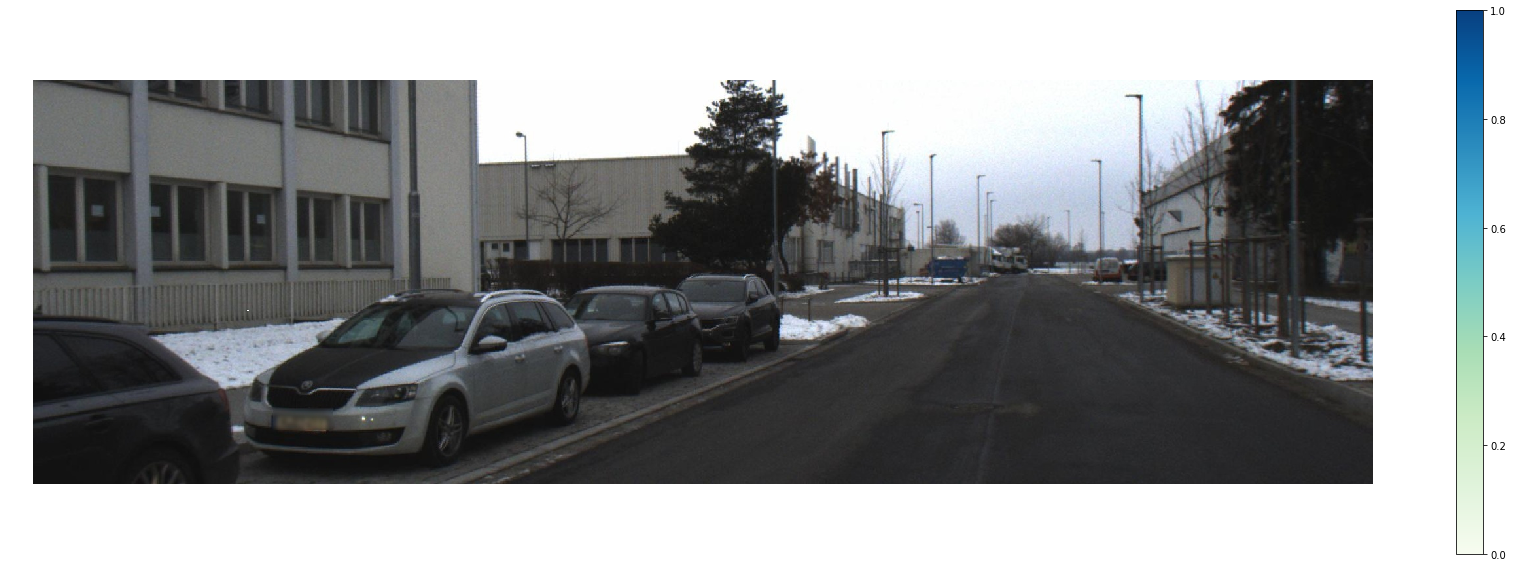

In [93]:
count_points(31,3)

Distance between Ego and Observed Vehicle = 18.891495041 mtr.
Rotation in quaternions is [0.9985837739177527, -0.03283711203726418, -0.016420043549037425, 0.038503931112009795]
Total LiDAR measurements for Observed vehicle = 71


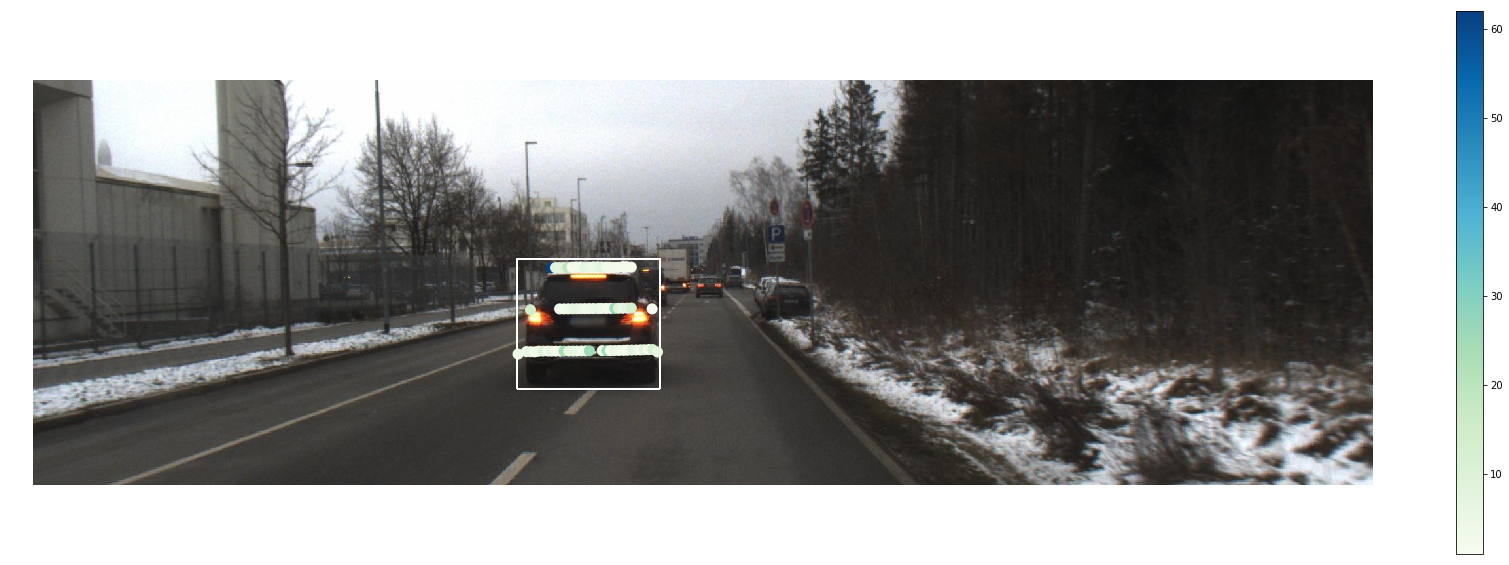

In [94]:
count_points(331,0)

Distance between Ego and Observed Vehicle = 14.18 mtr.
Rotation in quaternions is [0.9992488714358169, -0.031940326355938506, -0.01807124868862436, -0.01244742774055521]
Total LiDAR measurements for Observed vehicle = 85


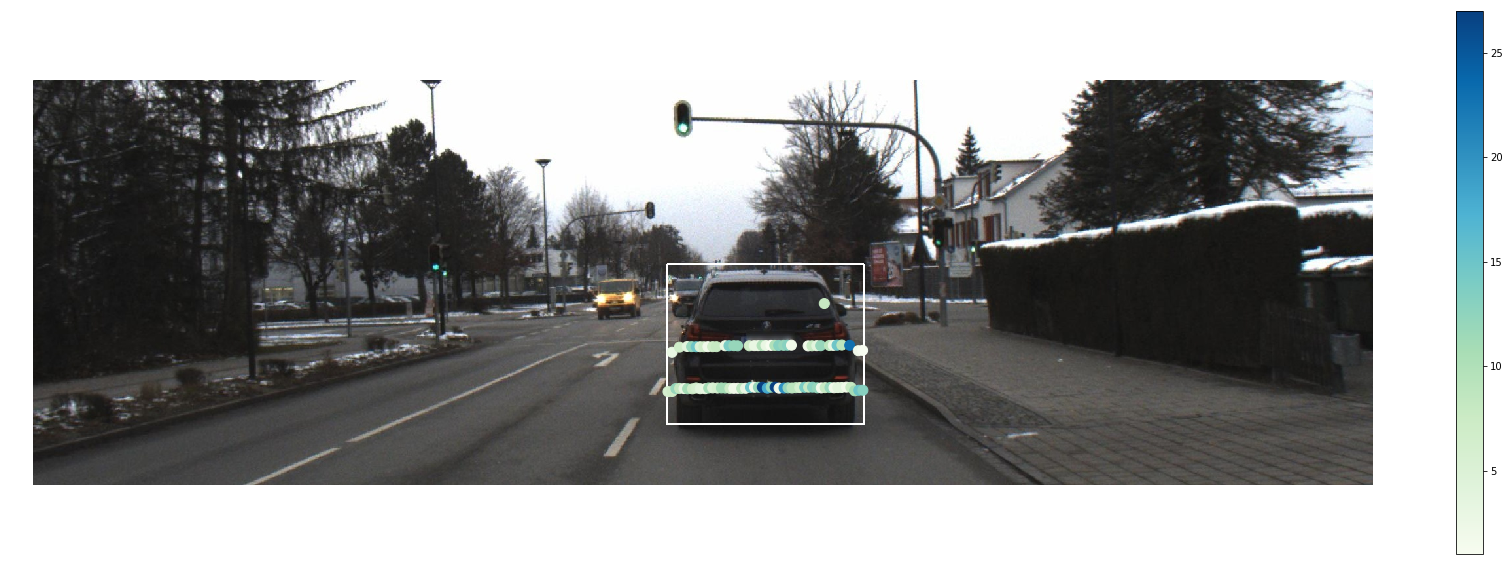

In [95]:
count_points(197,0)

Distance between Ego and Observed Vehicle = 10.7108792284 mtr.
Rotation in quaternions is [0.9990465311984655, -0.03173021801422336, -0.01842883468904657, -0.023655862213986162]
Total LiDAR measurements for Observed vehicle = 130


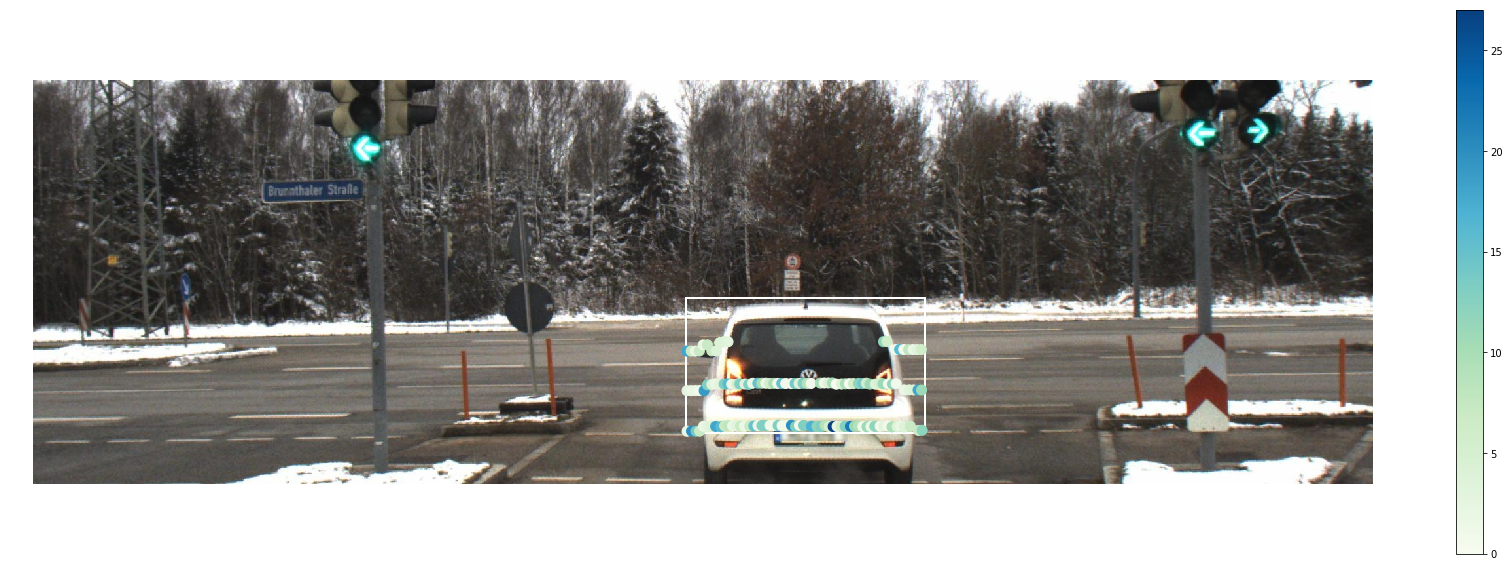

In [96]:
count_points(85,0)